In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score
from itertools import product
from scipy.sparse import coo_matrix
from utils_plot import *

In [66]:
# 1. Data Normalization
def preprocessing(alpha1, alpha2, N, ampl_threshold=0):

    targetnames = np.array(list(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()

    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    #N_norm = N - np.mean(N, axis=0, keepdims=True) #We will optimize the sparse matrix

    return alpha1_norm, alpha2_norm, N, targetnames_filtered, tf_names_filtered

In [67]:
# 2 Define Ridge Regression Model with Trainable Sparse W
class TrainableModel(nn.Module):
    def __init__(self, N, alpha, num_tfs, num_thetas):
        super(TrainableModel, self).__init__()

        # Convert N to COO format
        sparse_matrix = coo_matrix(N)

        # Get the nonzero indices and values
        self.i = torch.tensor(sparse_matrix.row, dtype=torch.long)
        self.j = torch.tensor(sparse_matrix.col, dtype=torch.long)
        values = torch.tensor(sparse_matrix.data, dtype=torch.float32)

        # Create W as a trainable vector for the non-zero elements of N
        self.W = nn.Parameter(torch.randn(len(values)) * 0.01)
        #self.W = nn.Parameter(values)

        # Trainable A matrix
        self.A = nn.Parameter(torch.randn(num_tfs, num_thetas) * 0.01)

        # Store original shape
        self.num_genes, self.num_tfs = N.shape

    def forward(self):
        # Create a sparse tensor for W
        W_sparse = torch.sparse_coo_tensor(
            indices=torch.stack([self.i, self.j]), 
            values=self.W, 
            size=(self.num_genes, self.num_tfs)
        )

        # Convert to dense tensor
        W_dense_tensor = W_sparse.to_dense()

        return torch.matmul(W_dense_tensor, self.A)  # Predicted alpha

    def loss(self, alpha_true):
        alpha_pred = self.forward()
        mse_loss = torch.mean((alpha_true - alpha_pred) ** 2)
        return mse_loss  # No regularization

In [68]:
def train_model(N, alpha, alpha_test, patience=10, num_epochs=1000, lr=0.01):
    num_genes, num_tfs = N.shape
    num_thetas = alpha.shape[1]
    
    model = TrainableModel(N, alpha, num_tfs, num_thetas)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_EV = -float("inf")
    best_W, best_A = None, None
    patience_counter = 0

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        loss = model.loss(alpha)
        loss.backward()
        optimizer.step()
            
        # Validation Step
        W_dense = torch.sparse_coo_tensor(
            indices=torch.stack([model.i, model.j]), 
            values=model.W.detach(), 
            size=(num_genes, num_tfs)
        ).to_dense().numpy()
        R_test = W_dense @ model.A.detach().numpy()
        EV_test = explained_variance_score(alpha_test.numpy(), R_test)

        # Check for early stopping
        if EV_test > best_EV+0.005:
            best_EV = EV_test
            best_W = model.W.clone().detach()
            best_A = model.A.clone().detach()
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
        
        if epoch % 25 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, EV_test: {EV_test:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best EV_test: {best_EV:.4f}")
            break

    # Convert learned W back to dense matrix
    W_dense = torch.sparse_coo_tensor(
        indices=torch.stack([model.i, model.j]), 
        values=model.W.detach(), 
        size=(num_genes, num_tfs)
    ).to_dense().numpy()

    return W_dense, model.A.detach().numpy()

In [69]:
# 4. Cross-Train
def cross_train(N, alpha1, alpha2):
    print("Training on α1, testing on α2...")
    W1, A1 = train_model(N, alpha1, alpha2)
    R_test1 = W1 @ A1
    EV1 = explained_variance_score(alpha2.numpy(), R_test1)

    print("Training on α2, testing on α1...")
    W2, A2 = train_model(N, alpha2, alpha1)
    R_test2 = W2 @ A2
    EV2 = explained_variance_score(alpha1.numpy(), R_test2)

    avg_EV = (EV1 + EV2) / 2
    print(f"Average EV: {avg_EV*100:.2f}%")
    
    return W1, A1, W2, A2

In [70]:
# Load Data & Run
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
ampl_threshold=0.2
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape, "\n")

N_tensor = torch.tensor(N_norm, dtype=torch.float32)  # (genes, TFs)
alpha1_tensor = torch.tensor(alpha1_norm, dtype=torch.float32)  # (genes, thetas)
alpha2_tensor = torch.tensor(alpha2_norm, dtype=torch.float32)  # (genes, thetas)

# Train and Cross-Test
W1, A1, W2, A2 = cross_train(N_tensor, alpha1_tensor, alpha2_tensor)

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 10
Kept genes: 812 (ampl > 0.2)
(812, 100) (812, 100) (812, 360) 

Training on α1, testing on α2...
Epoch 0, Loss: 0.0881, EV_test: -0.0529
Epoch 25, Loss: 0.0636, EV_test: 0.1745
Epoch 50, Loss: 0.0541, EV_test: 0.2574
Epoch 75, Loss: 0.0468, EV_test: 0.3151
Epoch 100, Loss: 0.0402, EV_test: 0.3634
Epoch 125, Loss: 0.0343, EV_test: 0.4052
Epoch 150, Loss: 0.0290, EV_test: 0.4414
Epoch 175, Loss: 0.0242, EV_test: 0.4719
Epoch 200, Loss: 0.0200, EV_test: 0.4971
Epoch 225, Loss: 0.0165, EV_test: 0.5173
Epoch 250, Loss: 0.0135, EV_test: 0.5334
Early stopping at epoch 273. Best EV_test: 0.5399
Training on α2, testing on α1...
Epoch 0, Loss: 0.0822, EV_test: -0.0532
Epoch 25, Loss: 0.0576, EV_test: 0.1683
Epoch 50, Loss: 0.0486, EV_test: 0.2438
Epoch 75, Loss: 0.0418, EV_test: 0.2997
Epoch 100, Loss: 0.0358, EV_test: 0.3471
Epoch 125, Loss: 0.0304, EV_test: 0.3893
Epoch 150, Loss: 0.0255, EV_test: 0.4272
E

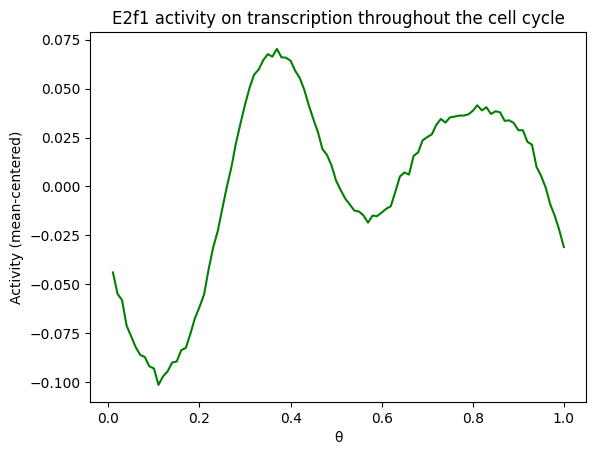

In [74]:
BP_nb = np.where(tf_names == 'E2f1')[0][0]
plot_binding_protein_activity(tf_names, A1, process, theta_smooth, BP_nb=BP_nb)

Train


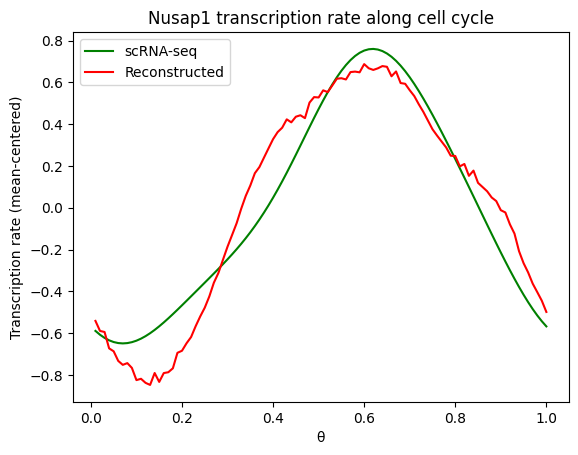

Test


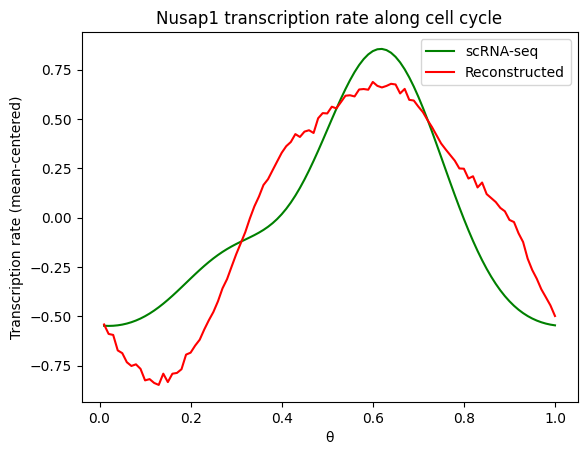

In [72]:
n = np.where(targetnames == 'Nusap1')[0][0]
#n = 12
print("Train")
plot_rate_comparison(targetnames, alpha1_tensor, W1 @ A1, process, theta_smooth, target_nb=n)
print("Test")
plot_rate_comparison(targetnames, alpha2_tensor, W1 @ A1, process, theta_smooth, target_nb=n)